<h1><center><font size="6">Movie Recommendation Model</font></center></h1>


<img src="https://storage.googleapis.com/kaggle-datasets-images/3405/5520/155700dd4800b6486f19dcab0e0b0cb8/dataset-card.jpg" width="400"></img>


# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Analysis preparation</a>  
- <a href='#3'>Data preparation and exploration</a>  
- <a href='#4'>Static rating model - top 10 movies</a>
- <a href='#5'>Recommendation simple models</a>  
- <a href='#6'>Conclusions</a>
- <a href='#7'>References</a>

# <a id="1">Introduction</a>  

## Data

We are using only reduced data from the movie dataset, as following:
*	**ratings_small**
*   **links_small**
*	**movies_metadata**  
*   **credits**  
*   **keywords**

We will create few recommendation models.

<a href="#0"><font size="1">Go to top</font></a>

# <a id="2">Analysis preparation</a>  

We start by loading the packages needed for the analysis.

## Load packages

In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
import os
pd.set_option('display.max_columns', 100)

## Read the data

Let's read the data. In this exercise, we store the data in the current directory.

In [2]:
PATH="../input"
print(os.listdir(PATH))

['movies_metadata.csv', 'ratings_small.csv', 'keywords.csv', 'links_small.csv', 'links.csv', 'ratings.csv', 'credits.csv']


In [3]:
ratings_df = pd.read_csv(os.path.join(PATH,"ratings_small.csv"), low_memory=False)

In [4]:
links_df = pd.read_csv(os.path.join(PATH,"links_small.csv"), low_memory=False)

In [5]:
movies_metadata_df = pd.read_csv(os.path.join(PATH,"movies_metadata.csv"), low_memory=False)

In [6]:
credits_df = pd.read_csv(os.path.join(PATH,"credits.csv"), low_memory=False)

In [7]:
keywords_df = pd.read_csv(os.path.join(PATH,"keywords.csv"), low_memory=False)

## Glimpse the data

Let's glimpse the data. We check the number of rows and columns, sample 5 rows and also run preliminary statistics (with *describe*) on the data.

In [8]:
print("Ratings data contains {} rows and {} columns".format(ratings_df.shape[0], ratings_df.shape[1]))
print("Links data contains {} rows and {} columns".format(links_df.shape[0], links_df.shape[1]))
print("Movie metadata contains {} rows and {} columns".format(movies_metadata_df.shape[0], movies_metadata_df.shape[1]))
print("Credits data contains {} rows and {} columns".format(credits_df.shape[0], credits_df.shape[1]))
print("Keywords data contains {} rows and {} columns".format(keywords_df.shape[0], keywords_df.shape[1]))

Ratings data contains 100004 rows and 4 columns
Links data contains 9125 rows and 3 columns
Movie metadata contains 45466 rows and 24 columns
Credits data contains 45476 rows and 3 columns
Keywords data contains 46419 rows and 2 columns


In [9]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [10]:
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


We will need to extract `genres` as lists of strings with movie genres.

In [11]:
movies_metadata_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [12]:
keywords_df.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [13]:
from ast import literal_eval
# Returns the list top l elements or entire list; whichever is more.
def get_list(x, l=5):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than l elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > l:
            names = names[:l]
        return names

    #Return empty list in case of missing/malformed data
    return []

movies_metadata_df['genres'] = movies_metadata_df['genres'].apply(literal_eval)
movies_metadata_df['genres'] = movies_metadata_df['genres'].apply(get_list)

Let's check also the data types.

In [14]:
pd.DataFrame({'feature':ratings_df.dtypes.index, 'dtype':ratings_df.dtypes.values})

,feature,dtype
0,userId,int64
1,movieId,int64
2,rating,float64
3,timestamp,int64


In [15]:
movies_metadata_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [16]:
pd.DataFrame({'feature':movies_metadata_df.dtypes.index, 'dtype':movies_metadata_df.dtypes.values})

,feature,dtype
0,adult,object
1,belongs_to_collection,object
2,budget,object
3,genres,object
4,homepage,object
5,id,object
6,imdb_id,object
7,original_language,object
8,original_title,object
9,overview,object


All features, `genre`, `id` and `title` are strings (or list of strings). 

Mean value for rating is ~3.5, min is 0.5 and max is 5. The ratings are given between Jan 1995 and Aug 2017.

In [17]:
ratings_df.describe()

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


In [18]:
import datetime
min_time = datetime.datetime.fromtimestamp(min(ratings_df.timestamp)).isoformat()
max_time = datetime.datetime.fromtimestamp(max(ratings_df.timestamp)).isoformat()
print('Timestamp for ratings from {} to {}:'.format(min_time, max_time))

Timestamp for ratings from 1995-01-09T11:46:49 to 2016-10-16T17:57:24:


## Check missing

We can confirm that we do not have missing data in `ratings_df`.
Let's also check `movies_metadata_df`.

In [19]:
def check_missing(data_df):
    total = data_df.isnull().sum().sort_values(ascending = False)
    percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

check_missing(ratings_df)

,timestamp,rating,movieId,userId
Total,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0


In [20]:
check_missing(movies_metadata_df)

,belongs_to_collection,homepage,tagline,overview,poster_path,runtime,status,release_date,imdb_id,original_language,vote_average,vote_count,revenue,spoken_languages,title,video,popularity,production_companies,production_countries,original_title,id,genres,budget,adult
Total,40972.000000,37684.000000,25054.000000,954.000000,386.000000,263.000000,87.000000,87.000000,17.000000,11.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,5.000000,3.000000,3.000000,0.0,0.0,0.0,0.0,0.0
Percent,90.115691,82.883913,55.104914,2.098271,0.848986,0.578454,0.191352,0.191352,0.037391,0.024194,0.013197,0.013197,0.013197,0.013197,0.013197,0.013197,0.010997,0.006598,0.006598,0.0,0.0,0.0,0.0,0.0


There are 6 movies without a title or 0.01%.
Let's drop these rows.

In [21]:
movies_metadata_df.dropna(subset=['title'], inplace=True)
check_missing(movies_metadata_df)

,belongs_to_collection,homepage,tagline,overview,poster_path,runtime,release_date,status,imdb_id,original_language,budget,genres,id,original_title,vote_count,popularity,vote_average,production_companies,production_countries,revenue,spoken_languages,title,video,adult
Total,40970.000000,37682.000000,25048.000000,954.000000,383.000000,257.000000,84.000000,81.000000,17.000000,11.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,90.123185,82.890453,55.098988,2.098548,0.842499,0.565332,0.184778,0.178179,0.037396,0.024197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
movies_metadata_df['id'] = pd.to_numeric(movies_metadata_df['id'])

## Filter only votes to movies in movies metadata

In [23]:
ratings_df.shape

(100004, 4)

In [24]:
ratings_df = ratings_df.merge(movies_metadata_df[['id']], left_on=['movieId'], right_on=['id'], how='inner')

In [25]:
ratings_df.shape

(44994, 5)


<a href="#0"><font size="1">Go to top</font></a>

# <a id="3">Data preparation</a>  

Let's start to verify in more detail and curate the data.


## Extract datetime

In [26]:
ratings_df['time_dt'] = ratings_df['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x))

In [27]:
ratings_df.head()

,userId,movieId,rating,timestamp,id,time_dt
0,1,1371,2.5,1260759135,1371,2009-12-14 02:52:15
1,4,1371,4.0,949810302,1371,2000-02-06 04:11:42
2,7,1371,3.0,851869160,1371,1996-12-29 14:19:20
3,19,1371,4.0,855193404,1371,1997-02-06 01:43:24
4,21,1371,3.0,853852263,1371,1997-01-21 13:11:03


Let's extract also few date/time attributes.

In [28]:
ratings_df['year'] = ratings_df['time_dt'].dt.year
ratings_df['month'] = ratings_df['time_dt'].dt.month
ratings_df['day'] = ratings_df['time_dt'].dt.day
ratings_df['dayofweek'] = ratings_df['time_dt'].dt.dayofweek

In [29]:
ratings_df[['year', 'month', 'day', 'dayofweek']].describe()

,year,month,day,dayofweek
count,44994.000000,44994.000000,44994.000000,44994.000000
mean,2004.002734,6.798773,15.465640,2.871272
std,5.986696,3.517710,8.780353,2.007390
min,1995.000000,1.000000,1.000000,0.000000
25%,2000.000000,4.000000,8.000000,1.000000
50%,2003.000000,7.000000,16.000000,3.000000
75%,2008.000000,10.000000,23.000000,5.000000
max,2016.000000,12.000000,31.000000,6.000000


All date and time looks fine, we will not need to eliminate or correct any value.

## Check date/time distribution

Let's proceed now to check date/time distribution. 

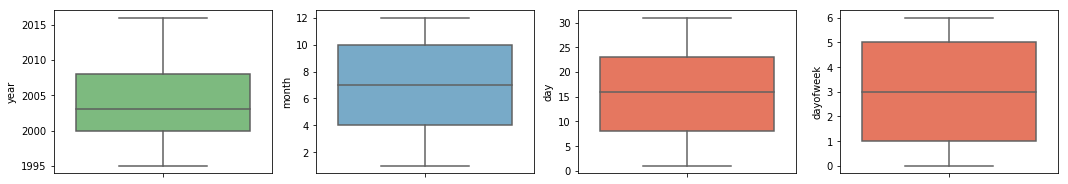

In [30]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(18,3))
s = sns.boxplot(ax = ax1, y="year", data=ratings_df, palette="Greens",showfliers=True)
s = sns.boxplot(ax = ax2, y="month", data=ratings_df, palette="Blues",showfliers=True)
s = sns.boxplot(ax = ax3, y="day", data=ratings_df, palette="Reds",showfliers=True)
s = sns.boxplot(ax = ax4, y="dayofweek", data=ratings_df, palette="Reds",showfliers=True)
plt.show()

Let's also show the number and average value of ratings variation in time.

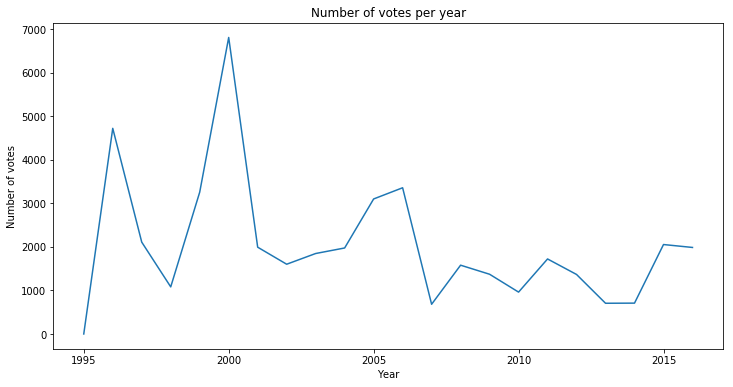

In [31]:
dt = ratings_df.groupby(['year'])['rating'].count().reset_index()
fig, (ax) = plt.subplots(ncols=1, figsize=(12,6))
plt.plot(dt['year'],dt['rating']); plt.xlabel('Year'); plt.ylabel('Number of votes'); plt.title('Number of votes per year')
plt.show()

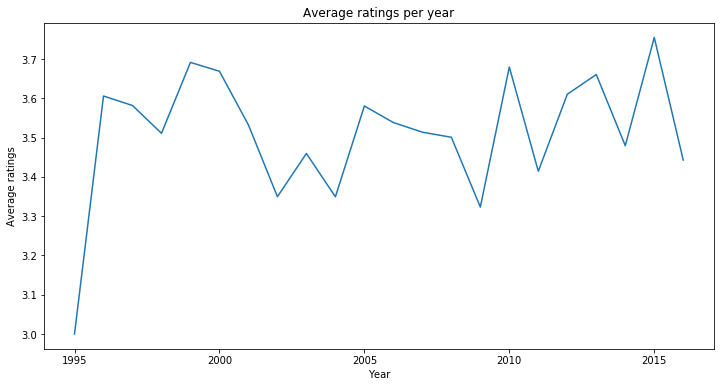

In [32]:
dt = ratings_df.groupby(['year'])['rating'].mean().reset_index()
fig, (ax) = plt.subplots(ncols=1, figsize=(12,6))
plt.plot(dt['year'],dt['rating']); plt.xlabel('Year'); plt.ylabel('Average ratings'); plt.title('Average ratings per year')
plt.show()

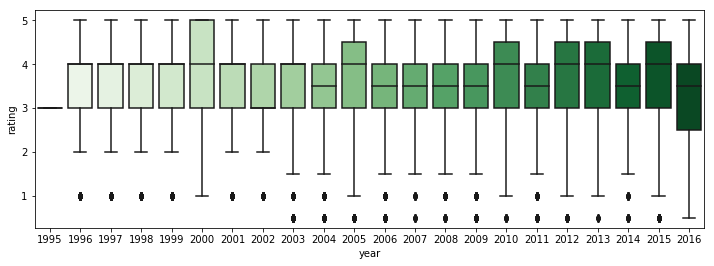

In [33]:
fig, (ax) = plt.subplots(ncols=1, figsize=(12,4))
s = sns.boxplot(x='year', y="rating", data=ratings_df, palette="Greens",showfliers=True)
plt.show()

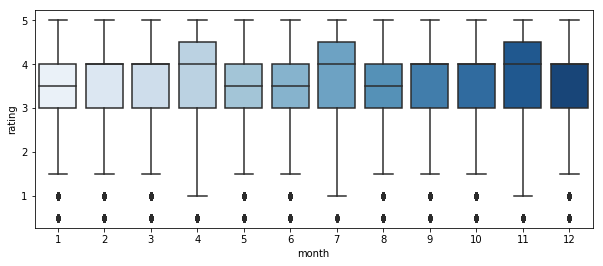

In [34]:
fig, (ax) = plt.subplots(ncols=1, figsize=(10,4))
s = sns.boxplot(x='month', y="rating", data=ratings_df, palette="Blues",showfliers=True)
plt.show()

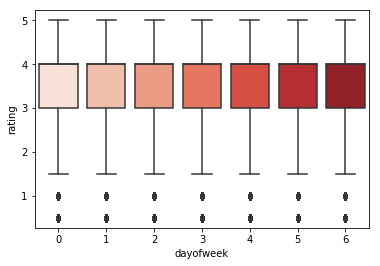

In [35]:
fig, (ax) = plt.subplots(ncols=1, figsize=(6,4))
s = sns.boxplot(x='dayofweek', y="rating", data=ratings_df, palette="Reds",showfliers=True)
plt.show()

Observations:
* We are not observing a special behavior other than variation in time of the ratings averages, with a descending trend from 1995 to 2004, also with 2 peaks in 1997 and 1999 and ascending trend since 2004 to 2012, to start decreasing again.
* Number of votes shows a lot of peaks and valleys, and also an ascendent trend to 2005, followed by a descending one from 2005, a sharp increase to 2015.
* There are a number of outliers for each year, month and day of week. We observe a strange alignment of the rating distribution per year intervals 1996-2002, 2003-2011 and 2012-2017 which could prompt us to conclude that the selection used some artificial sampling.

## Users distribution


Let's check if we have special users (users that give many votes, users that give preponderently high ratings, users that give mostly low ratings, users that are giving the perfect average value). Also, users with only one vote.

In [36]:
print("There is a total of {} users, with an average number of {} votes.".format(ratings_df.userId.nunique(), \
                                                round(ratings_df.shape[0]/ratings_df.userId.nunique()),2))

There is a total of 671 users, with an average number of 67 votes.


In [37]:
print("Top 5 voting users:\n")
tmp = ratings_df.userId.value_counts()[:5]
pd.DataFrame({'Votes':tmp.values, 'Id':tmp.index})

Top 5 voting users:



,Votes,Id
0,896,564
1,753,547
2,565,15
3,553,73
4,542,452


In [38]:
tmp = ratings_df.userId.value_counts()
df = pd.DataFrame({'Votes':tmp.values, 'Id':tmp.index})
print("There are {} users that voted only once.".format(df[df['Votes']==1].nunique().values[0]))

IndexError: index 0 is out of bounds for axis 0 with size 0

In [39]:
tmp = ratings_df.groupby(['userId'])['rating'].mean().reset_index()
tmp['rating'] = tmp['rating'].apply(lambda x: round(x,3))
df_max = tmp[tmp['rating']==5]
df_min = tmp[tmp['rating']==0.5]
print("Users giving only '5': {}\nUsers giving only '0.5':{}".format(df_max.shape[0], df_min.shape[0]))

Users giving only '5': 1
Users giving only '0.5':0


In [40]:
mean_rating = round(ratings_df['rating'].mean(),3)
print("Average value of rating is {}.".format(mean_rating))
print("There are {} users that have their average score with the overall average score (approx. with 3 decimals).".format(\
                            tmp[tmp['rating']==mean_rating]['userId'].nunique()))

Average value of rating is 3.561.
There are 1 users that have their average score with the overall average score (approx. with 3 decimals).


## Movie distribution

Let's see what are the movies with the largest number of votes, with the biggest rating, with the lowest rating, how many movies have ratings close to average rating.

In [41]:
print("There is a total of {} movies, with an average number of {} votes.".format(ratings_df.movieId.nunique(), \
                                                round(ratings_df.shape[0]/ratings_df.movieId.nunique()),2))

There is a total of 2830 movies, with an average number of 16 votes.


In [42]:
print("Top 10 voted movies:\n")
tmp = ratings_df.movieId.value_counts()[:10]
pd.DataFrame({'Votes':tmp.values, 'id':tmp.index})

Top 10 voted movies:



,Votes,id
0,324,296
1,311,318
2,304,593
3,291,260
4,274,480
5,244,527
6,228,110
7,224,608
8,218,780
9,215,588


Let's see what movies are those:

In [43]:
top_10 = pd.DataFrame({'Votes':tmp.values, 'id':tmp.index}).merge(movies_metadata_df)
top_10

,Votes,id,adult,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,324,296,False,"{'id': 528, 'name': 'The Terminator Collection...",200000000,"[Action, Thriller, Science Fiction]",NaN,tt0181852,en,Terminator 3: Rise of the Machines,It's been 10 years since John Connor saved Ear...,20.818907,/lz4xYdF1n09lyiCfZWtWT44SZiG.jpg,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...",2003-07-02,435000000.0,109.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Machines Will Rise.,Terminator 3: Rise of the Machines,False,5.9,2177.0
1,311,318,False,NaN,8000000,"[Drama, Thriller]",NaN,tt0120753,en,The Million Dollar Hotel,The Million Dollar Hotel starts with a jump fr...,4.938231,/4wxOzpCjXY2RQgS3YoHuvKdItTF.jpg,"[{'name': 'Kintop Pictures', 'id': 1490}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-02-09,0.0,122.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,The Million Dollar Hotel,False,5.9,76.0
2,304,593,False,NaN,0,"[Drama, Science Fiction, Adventure, Mystery]",NaN,tt0069293,ru,Солярис,Ground control has been receiving strange tran...,11.059785,/nsGLKlwEOtqatz8yRdxOlAw5utr.jpg,"[{'name': 'Mosfilm', 'id': 5120}, {'name': 'Cr...","[{'iso_3166_1': 'RU', 'name': 'Russia'}]",1972-03-20,0.0,167.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Solaris,False,7.7,364.0
3,291,260,False,NaN,0,"[Action, Thriller, Mystery]",NaN,tt0026029,en,The 39 Steps,"While on vacation in London, Canadian Richard ...",5.865697,/9v283GWj9a0AC8wwC4zriNqY1lZ.jpg,[{'name': 'Gaumont British Picture Corporation...,"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",1935-06-01,0.0,86.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Handcuffed to the girl who double-crossed him,The 39 Steps,False,7.4,217.0
4,274,480,False,NaN,0,"[Comedy, Drama, Romance]",NaN,tt0265343,hi,Monsoon Wedding,From an exciting Indian wedding comes a relati...,10.625504,/2LysDwqhK0GlGtQqjPCiDeiBoqU.jpg,"[{'name': 'IFC Films', 'id': 307}, {'name': 'M...","[{'iso_3166_1': 'IN', 'name': 'India'}]",2001-08-30,0.0,114.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,"A stressed father, a bride-to-be with a secret...",Monsoon Wedding,False,6.8,59.0
5,244,527,False,"{'id': 300546, 'name': 'Once were Warriors Col...",0,[Drama],NaN,tt0110729,en,Once Were Warriors,A drama about a Maori family lving in Auckland...,4.025276,/8QF48QS5lvtrhOclt22RFz3bSQm.jpg,"[{'name': 'Avalon Studios', 'id': 293}, {'name...","[{'iso_3166_1': 'NZ', 'name': 'New Zealand'}]",1994-09-02,2201126.0,99.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,"A family in crisis, a life in chaos... Nothing...",Once Were Warriors,False,7.6,106.0
6,228,110,False,"{'id': 131, 'name': 'Three Colors Collection',...",0,"[Drama, Mystery, Romance]",NaN,tt0111495,fr,Trois couleurs : Rouge,Red This is the third film from the trilogy by...,7.832755,/77CFEssoKesi4zvtADEpIrSKhA3.jpg,"[{'name': 'Zespół Filmowy TOR', 'id': 38}, {'n...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",1994-05-27,0.0,99.0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Released,NaN,Three Colors: Red,False,7.8,246.0
7,224,608,False,"{'id': 86055, 'name': 'Men In Black Collection...",140000000,"[Action, Adventure, Comedy, Science Fiction]",http://www.sonypictures.com/homevideo/meninbla...,tt0120912,en,Men in Black II,"Kay and Jay reunite to provide our best, last ...",16.775716,/qWjRfBwr4VculczswwojXgoU0mq.jpg,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'US', 'name': 'United States o...",2002-07-03,441818803.0,88.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Same Planet. New Scum.,Men in Black II,False,6.1,3188.0
8,218,780,False,NaN,0,"[Drama, History]",NaN,tt0019254,fr,La passion de Jeanne d'Arc,"A classic of the si

Observation: now all the movies in the `ratings_df` are present also in `movies_metadata_df` dataset.

In [44]:
tmp = ratings_df.movieId.value_counts()
df = pd.DataFrame({'Votes':tmp.values, 'Id':tmp.index})
print("There are {} movies that were voted only once.".format(df[df['Votes']==1].nunique().values[0]))

There are 1 movies that were voted only once.


In [45]:
tmp = ratings_df.groupby(['movieId'])['rating'].mean().reset_index()
tmp['rating'] = tmp['rating'].apply(lambda x: round(x,3))
df_max = tmp[tmp['rating']==5]
df_min = tmp[tmp['rating']==0.5]
print("Movies with only '5': {}\nMovies with only '0.5':{}".format(df_max.shape[0], df_min.shape[0]))

Movies with only '5': 86
Movies with only '0.5':26


**Note**: these values should be interpreted considering that we only use a 20% sample from the ratings_df total data.

In [46]:
mean_rating = round(ratings_df['rating'].mean(),3)
print("Average value of rating is {}.".format(mean_rating))
print("There are {} movies that have their average score with the overall average score (approx. with 3 decimals).".format(\
                            tmp[tmp['rating']==mean_rating]['movieId'].nunique()))

Average value of rating is 3.561.
There are 1 movies that have their average score with the overall average score (approx. with 3 decimals).


Let's check now genres distribution.

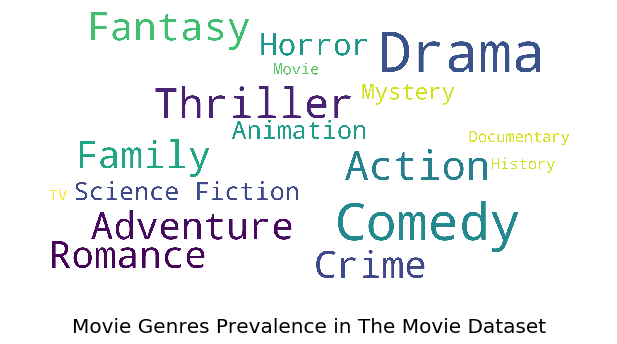

In [47]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=17,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(movies_metadata_df['genres'], title = 'Movie Genres Prevalence in The Movie Dataset')

<a href="#0"><font size="1">Go to top</font></a>


# <a id="4">Static rating model - top 10 movies</a>  

Let's build now a baseline static rating model to create the top 10 movies.  

We use the formulas borrowed from two Kernels:
* https://www.kaggle.com/fabiendaniel/film-recommendation-engine    
* https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system/data  


We will use for this the **IMDB** weighted rating formula, as following:

$$IMDB = {\frac{v}{v+m}}{R} + {\frac{m}{v+m}}{C} $$

where:
* **IMDB** is weighted rating;  
* **v** is the number of votes for the movie;
* **m** is the minimum votes required to be included in the calculation;
* **R** is the average rating of the movie; 
* **C** is the mean vote across the whole set.

Let's calculate these values. For `m`, we consider quantile 0.9.

In [48]:
tmp = ratings_df.groupby(['movieId'])['rating'].mean()
R = pd.DataFrame({'id':tmp.index, 'R': tmp.values})
tmp = ratings_df.groupby(['movieId'])['rating'].count()
v = pd.DataFrame({'id':tmp.index, 'v': tmp.values})
C = ratings_df['rating'].mean()

In [49]:
m_df = movies_metadata_df.merge(R, on=['id'])
m_df = m_df.merge(v, on=['id'])
m_df['C'] = C
m= m_df['v'].quantile(0.9)
m_df['m'] = m

In [50]:
m_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,R,v,C,m
0,False,NaN,60000000,"[Action, Crime, Drama, Thriller]",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",17.924927,/zMyfPUelumio3tiDKPffaUpsQTD.jpg,"[{'name': 'Regency Enterprises', 'id': 508}, {...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0,3.593750,16,3.560986,44.0
1,False,"{'id': 645, 'name': 'James Bond Collection', '...",58000000,"[Adventure, Action, Thriller]",http://www.mgm.com/view/movie/757/Goldeneye/,710,tt0113189,en,GoldenEye,James Bond must unmask the mysterious head of ...,14.686036,/5c0ovjT41KnYIHYuF4AWsTe3sKh.jpg,"[{'name': 'United Artists', 'id': 60}, {'name'...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",1995-11-16,352194034.0,130.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,No limits. No fears. No substitutes.,GoldenEye,False,6.6,1194.0,1.500000,2,3.560986,44.0
2,False,NaN,98000000,"[Action, Adventure]",NaN,1408,tt0112760,en,Cutthroat Island,"Morgan Adams and her slave, William Shaw, are ...",7.284477,/odM9973kIv9hcjfHPp6g6BlyTIJ.jpg,"[{'name': 'Le Studio Canal+', 'id': 183}, {'na...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",1995-12-22,10017322.0,119.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The Course Has Been Set. There Is No Turning B...,Cutthroat Island,False,5.7,137.0,3.616279,43,3.560986,44.0
3,False,NaN,52000000,"[Drama, Crime]",NaN,524,tt0112641,en,Casino,The life of the gambling paradise – Las Vegas ...,10.137389,/xo517ibXBDdYQY81j0WIG7BVcWq.jpg,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",1995-11-22,116112375.0,178.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,No one stays at the top forever.,Casino,False,7.8,1343.0,3.555556,36,3.560986,44.0
4,False,NaN,16500000,"[Drama, Romance]",NaN,4584,tt0114388,en,Sense and Sensibility,"Rich Mr. Dashwood dies, leaving his second wif...",10.673167,/lA9HTy84Bb6ZwNeyoZKobcMdpMc.jpg,"[{'name': 'Columbia Pictures Corporation', 'id...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",1995-12-13,135000000.0,136.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Lose your heart and come to your senses.,Sense and Sensibility,False,7.2,364.0,5.000000,1,3.560986,44.0


In [51]:
m_df['IMDB'] = (m_df['v'] / (m_df['v'] + m_df['m'])) * m_df['R'] + (m_df['m'] / (m_df['v'] + m_df['m'])) * m_df['C']

We can show now the top 10 movies according to the IMDB score.

In [52]:
m_df.sort_values(by=['IMDB'], ascending=False).head(10)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,R,v,C,m,IMDB
747,False,NaN,8000000,"[Drama, Thriller]",NaN,318,tt0120753,en,The Million Dollar Hotel,The Million Dollar Hotel starts with a jump fr...,4.938231,/4wxOzpCjXY2RQgS3YoHuvKdItTF.jpg,"[{'name': 'Kintop Pictures', 'id': 1490}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-02-09,0.0,122.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,The Million Dollar Hotel,False,5.9,76.0,4.487138,311,3.560986,44.0,4.372348
102,False,NaN,21000000,"[Comedy, Drama, Romance]",NaN,858,tt0108160,en,Sleepless in Seattle,A young boy who tries to set his dad up on a d...,10.234919,/afkYP15OeUOD0tFEmj6VvejuOcz.jpg,"[{'name': 'TriStar Pictures', 'id': 559}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1993-06-24,227799884.0,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"What if someone you never met, someone you nev...",Sleepless in Seattle,False,6.5,630.0,4.487500,200,3.560986,44.0,4.320424
48,False,"{'id': 300546, 'name': 'Once were Warriors Col...",0,[Drama],NaN,527,tt0110729,en,Once Were Warriors,A drama about a Maori family lving in Auckland...,4.025276,/8QF48QS5lvtrhOclt22RFz3bSQm.jpg,"[{'name': 'Avalon Studios', 'id': 293}, {'name...","[{'iso_3166_1': 'NZ', 'name': 'New Zealand'}]",1994-09-02,2201126.0,99.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,"A family in crisis, a life in chaos... Nothing...",Once Were Warriors,False,7.6,106.0,4.303279,244,3.560986,44.0,4.189873
1042,False,"{'id': 528, 'name': 'The Terminator Collection...",200000000,"[Action, Thriller, Science Fiction]",NaN,296,tt0181852,en,Terminator 3: Rise of the Machines,It's been 10 years since John Connor saved Ear...,20.818907,/lz4xYdF1n09lyiCfZWtWT44SZiG.jpg,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...",2003-07-02,435000000.0,109.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Machines Will Rise.,Terminator 3: Rise of the Machines,False,5.9,2177.0,4.256173,324,3.560986,44.0,4.173053
929,False,"{'id': 86055, 'name': 'Men In Black Collection...",140000000,"[Action, Adventure, Comedy, Science Fiction]",http://www.sonypictures.com/homevideo/meninbla...,608,tt0120912,en,Men in Black II,"Kay and Jay reunite to provide our best, last ...",16.775716,/qWjRfBwr4VculczswwojXgoU0mq.jpg,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'US', 'name': 'United States o...",2002-07-03,441818803.0,88.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Same Planet. New Scum.,Men in Black II,False,6.1,3188.0,4.256696,224,3.560986,44.0,4.142475
174,False,NaN,0,"[Action, Thriller, Mystery]",NaN,260,tt0026029,en,The 39 Steps,"While on vacation in London, Canadian Richard ...",5.865697,/9v283GWj9a0AC8wwC4zriNqY1lZ.jpg,[{'name': 'Gaumont British Picture Corporation...,"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",1935-06-01,0.0,86.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Handcuffed to the girl who double-crossed him,The 39 Steps,False,7.4,217.0,4.221649,291,3.560986,44.0,4.134876
925,False,NaN,0,"[Action, Western, Thriller]",NaN,4993,tt0062626,en,5 Card Stud,The players in an ongoing poker game are being...,1.372254,/gev2WX8alGl0f7Ql0JZfeOY8uDg.jpg,"[{'name': 'Paramount Pictures', 'id': 4}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1968-07-28,0.0,103.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A card cheat was hung... then all hell broke l...,5 Card Stud,False,6.0,20.0,4.182500,200,3.560986,44.0,4.070424
1804,False,NaN,35000000,[Comedy],http://licensetowedthemovie.warnerbros.com/,2959,tt0762114,en,License to Wed,"Newly engaged, Ben and Sadie can't wait to sta...",7.102076,/9I8NiY5cfFmwgI8Y5NKQqsuDawS.jpg,"[{'name': 'Village Roadshow Picture

The result: 

## <font color="blue">Static IMDB model: top 10</font>  

This is our reference model.

In [53]:
m_df[['title', 'IMDB']].sort_values(by=['IMDB'], ascending=False).head(10)

,title,IMDB
747,The Million Dollar Hotel,4.372348
102,Sleepless in Seattle,4.320424
48,Once Were Warriors,4.189873
1042,Terminator 3: Rise of the Machines,4.173053
929,Men in Black II,4.142475
174,The 39 Steps,4.134876
925,5 Card Stud,4.070424
1804,License to Wed,4.067819
650,Solaris,4.065182
2400,Shriek If You Know What I Did Last Friday the ...,4.060701


Let's compare this reference model with top 10 by only number of votes and by total value of votes.

## <font color="grey">Top 10 by number of votes</font>

In [54]:
m_df['R_x_v'] = m_df['R'] * m_df['v']

In [55]:
m_df[['title', 'v']].sort_values(by=['v'], ascending=False).head(10)

,title,v
1042,Terminator 3: Rise of the Machines,324
747,The Million Dollar Hotel,311
650,Solaris,304
174,The 39 Steps,291
885,Monsoon Wedding,274
48,Once Were Warriors,244
53,Three Colors: Red,228
929,Men in Black II,224
1109,The Passion of Joan of Arc,218
1646,Silent Hill,215


## <font color="grey">Top 10 by product of average rating and number of votes</font>

In [56]:
m_df[['title', 'R_x_v']].sort_values(by=['R_x_v'], ascending=False).head(10)

,title,R_x_v
747,The Million Dollar Hotel,1395.5
1042,Terminator 3: Rise of the Machines,1379.0
650,Solaris,1258.0
174,The 39 Steps,1228.5
48,Once Were Warriors,1050.0
885,Monsoon Wedding,1015.5
929,Men in Black II,953.5
53,Three Colors: Red,899.5
102,Sleepless in Seattle,897.5
1804,License to Wed,844.0


## Memory cleanup

In [57]:
del tmp, top_10
gc.collect()

8830

## <a id="5">Recommendation simple models</a>


## Simple model using similarities of movie title

The model will use similarities, calculated based on movie title.

We will use the already calculated `m_df` dataset.   
The methods to calculate cosine simmilarities are taken from:   
* https://www.kaggle.com/fabiendaniel/film-recommendation-engine    
* https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system/data  

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english',max_features=10000)
tokens = m_df[['title']]
tokens['title'] = tokens['title'].fillna('')
tfidf_matrix = tfidf.fit_transform(tokens['title'])
print(tfidf_matrix.shape)
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print(cosine_sim.shape)
indices = pd.Series(tokens.index, index=tokens['title']).drop_duplicates()
def get_recommendations(title, cosine_sim=cosine_sim):
    # index of the movie that matches the title
    idx = indices[title]

    # similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # movie indices
    movie_indices = [i[0] for i in sim_scores]

    # top 10 most similar movies
    return tokens['title'].iloc[movie_indices]


(2831, 3222)
(2831, 2831)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [59]:
get_recommendations('The Million Dollar Hotel')

1458       Million Dollar Baby
1191    One Million Years B.C.
2407        Hotel Very Welcome
1242    How to Steal a Million
1459              Hotel Rwanda
2331          Heartbreak Hotel
1536      Billion Dollar Brain
0                         Heat
1                    GoldenEye
2             Cutthroat Island
Name: title, dtype: object

In [60]:
get_recommendations('Sleepless in Seattle')

0                         Heat
1                    GoldenEye
2             Cutthroat Island
3                       Casino
4        Sense and Sensibility
5                   Four Rooms
6                   Get Shorty
7            Leaving Las Vegas
8    The City of Lost Children
9               Twelve Monkeys
Name: title, dtype: object

## Combined model, using similarity and popularity

This model uses both similarity factor, based on movie title and popularity score, based on IMDB score.

We modify the `get_recommendation` function to return a number of 50 similar titles; we order the titles using popularity score. 

Inspiration for the following functions are from:  

* https://www.kaggle.com/fabiendaniel/film-recommendation-engine    
* https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system/data  

In [61]:
tfidf = TfidfVectorizer(stop_words='english',max_features=10000)
tokens = m_df[['title']]
tokens['title'] = tokens['title'].fillna('')
tfidf_matrix = tfidf.fit_transform(tokens['title'])
print(tfidf_matrix.shape)
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print(cosine_sim.shape)
indices = pd.Series(tokens.index, index=tokens['title']).drop_duplicates()

(2831, 3222)
(2831, 2831)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [62]:
def get_imdb_score(df, indices):
    # select the data from similarity indices
    tmp = df[df.id.isin(indices)]
    # sort the data by IMDB score
    tmp = tmp.sort_values(by='IMDB', ascending=False)
    # return title and IMDB score
    return tmp[['title','IMDB']].head(10)

In [63]:
def get_10_recommendations_simpol(title, cosine_sim=cosine_sim):
    # index of the movie that matches the title
    idx = indices[title]

    # similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # scores of the 20 most similar movies
    sim_scores = sim_scores[1:21]
    
    # movie indices
    movie_indices = [i[0] for i in sim_scores]

    # get popularity scores
    pop_scores = get_imdb_score(m_df, movie_indices)
    
    return list(pop_scores['title'])


In [64]:
get_10_recommendations_simpol('The Million Dollar Hotel')

['Judgment Night',
 'Star Wars',
 'Jesus',
 'Ariel',
 'Four Rooms',
 'Finding Nemo',
 'Shadows in Paradise']

In [65]:
get_10_recommendations_simpol('Judgment Night')

['Cat on a Hot Tin Roof',
 'Marlowe',
 'Three Colors: Blue',
 'The Secret Life of Words',
 'Harry Potter and the Half-Blood Prince',
 'Lady Snowblood',
 'Hellboy',
 'Sleepy Hollow',
 'The Aviator',
 'Short Circuit']

In [66]:
get_10_recommendations_simpol('Fahrenheit 9/11')

['Dancer in the Dark',
 'The Dark',
 'Judgment Night',
 'Star Wars',
 'Forrest Gump',
 'American Beauty',
 'The Fifth Element',
 'Ariel',
 'Four Rooms',
 'Finding Nemo']

<a href="#0"><font size="1">Go to top</font></a>


# <a id="6">Conclusion</a>  

Three simple recommendation models were created, as following:

* One model, user agnostic, based on ratings averages per movie and number of votes, it is basically the IMDB rating model; this model provide a top-10 list of movies recommendation, starting from a movie selected by a user;  
* One model, depending on simmilarities of titles;
* One model, depending on similarities of titles and IMDB rating.


# <a id="8">References</a>  

I took inspiration from several sources. 

[1] https://medium.com/recombee-blog/machine-learning-for-recommender-systems-part-1-algorithms-evaluation-and-cold-start-6f696683d0ed  
[2] https://www.kaggle.com/fabiendaniel/film-recommendation-engine  
[3] https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system/data  


<a href="#0"><font size="1">Go to top</font></a>